This is an attempt to create an EfficientNet building block: MBConv.

I am going to implement this is a couple ways:
1) using the Tensorflow/Keras Functional API
2) using a custom class for Keras


This is the unit we are implementing here.  It is useful in Image classification architectures

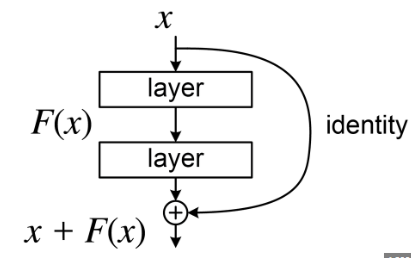

# Setup

In [105]:
import os
import sys
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
import random
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import wfutils

ROOT_DIR = "."
NOTEBOOK_ID = "ResidualNetworks"
IMAGE_PATH = os.path.join(ROOT_DIR, "images", NOTEBOOK_ID)


# obtain the data

Just a repeat of what we've been doing

In [106]:
data_path = Path("../data/smalldataset")

# Setup train and testing paths
train_dir = Path(data_path, "train")
test_dir = Path(data_path, "test")
val_dir = Path(data_path, "val")

train_dir, test_dir, val_dir

(PosixPath('../data/smalldataset/train'),
 PosixPath('../data/smalldataset/test'),
 PosixPath('../data/smalldataset/val'))

In [107]:
data_dir = pathlib.Path(train_dir) 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Achillea_millefolium' 'Aconitum_columbianum' 'Allium_acuminatum'
 'Allium_cernuum' 'Amelanchier_alnifolia' 'Androsace_septentrionalis'
 'Antennaria_rosea' 'Anticlea_elegans' 'Aquilegia_coerulea'
 'Caltha_leptosepala' 'Campanula_rotundifolia' 'Cardus_nutans'
 'Castilleja_linariifolia' 'Castilleja_rhexifolia'
 'Castilleja_septentrionalis' 'Chamaenerion_angustifolium'
 'Clematis_hirsutissima' 'Corydalis_caseana' 'Dasiphora_fruticosa'
 'Delphinium_barbeyi' 'Eremogone_fendleri' 'Erigeron_coulteri'
 'Erigeron_divergens' 'Erigeron_flagellaris' 'Erigeron_speciosus'
 'Eriogonum_umbellatum' 'Eriogonum_umbellatum_var_majus'
 'Erythronium Grandiflorum' 'Frasera_speciosa' 'Gentiana_parryi'
 'Geranium_richardsonii' 'Geum_triflorum' 'Heterotheca_villosa'
 'Hymenoxys_hoopesii' 'Ipomopsis_aggregata' 'Ligusticum_porteri'
 'Lupinus_argenteus' 'Mertensia_ciliata' 'Nuphar_polysepala'
 'Paxistima_myrsinites' 'Pedicularis_bracteosa' 'Pedicularis_groenlandica'
 'Pedicularis_racemosa' 'Penstemon_mensarum' 'P

In [108]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [109]:
IMAGE_HEIGHT = 224  # just because it is common practice and somewhat small... can be whatever
IMAGE_WIDTH = 224
IMAGE_DEPTH = 3  # rgb

batch_size = 16
epochs = 10

In [110]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=batch_size,           # number of images to process at a time 
                                               target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # convert all images to be 224 x 224
                                               class_mode="categorical",     # type of problem we're working on  - 'input' is used for autoencoders, 'categorical' is for classification
                                               seed=42,
                                               )

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=batch_size,           # number of images to process at a time 
                                               target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # convert all images to be 224 x 224
                                               class_mode="categorical",     # type of problem we're working on  - 'input' is used for autoencoders like this one
                                               seed=42)

val_data = test_datagen.flow_from_directory(val_dir,
                                               batch_size=batch_size,
                                               target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                               class_mode="categorical",
                                               seed=42)

Found 5308 images belonging to 66 classes.
Found 1718 images belonging to 66 classes.
Found 1718 images belonging to 66 classes.


In [111]:
X, y = next(val_data)
X.shape, y.shape

((16, 224, 224, 3), (16, 66))

In [112]:
for data_batch, labels_batch in train_data:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Labels batch shape: {labels_batch.shape}")
    break

Data batch shape: (16, 224, 224, 3)
Labels batch shape: (16, 66)


In [113]:
for data_batch, labels_batch in test_data:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Labels batch shape: {labels_batch.shape}")
    break

Data batch shape: (16, 224, 224, 3)
Labels batch shape: (16, 66)


# Tensorflow Functional API

In [114]:
#keras.layers.Flatten(input_shape=[IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH]),

In [115]:
input_ = keras.layers.Input(shape=[IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH])
flatten = keras.layers.Flatten(input_shape=[IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)


residual_unit = keras.models.Model(inputs=[input_], outputs=[output], name="Residual_Unit")

In [116]:
residual_unit.summary()

Model: "Residual_Unit"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 dense_16 (Dense)            (None, 224, 224, 30)         120       ['input_3[0][0]']             
                                                                                                  
 dense_17 (Dense)            (None, 224, 224, 30)         930       ['dense_16[0][0]']            
                                                                                                  
 concatenate_2 (Concatenate  (None, 224, 224, 33)         0         ['input_3[0][0]',             
 )                                                                   'dense_17[0][0]']

# Keras Layer class

In [117]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,  padding="SAME", use_bias=False)

class MyResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)

        # Set our activation function
        self.activation = keras.activations.get(activation) #get an activation layer based on the 
        # Set the layers
        self.main_layers = [ DefaultConv2D(filters, strides=strides),
                            keras.layers.BatchNormalization(),
                            self.activation,
                            DefaultConv2D(filters),
                            keras.layers.BatchNormalization()]
        # define skip layers (default to empty)
        self.skip_layers = []
        # add layers to skip, (i.e. stride across)
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=3, strides=strides, padding ="SAME"),
                keras.layers.BatchNormalization()]  #follow each Conv with a norm

    def call(self, inputs):
        i = inputs
        for layer in self.main_layers:
            i = layer(i)
        skip = inputs
        for layer in self.skip_layers:
            skip = layer(skip)
            # return the input + the result of the skip layers
        return self.activation(i + skip) # relu the output

In [118]:
# from tensorflow.keras.layers import Add, Conv2D, BatchNormalization, Activation

# class MyResidualUnit(tf.keras.layers.Layer):
#     def __init__(self, filters, strides=1, **kwargs):
#         super().__init__(**kwargs)
#         self.strides = strides
#         self.filters = filters
#         self.conv1 = Conv2D(filters, kernel_size=3, strides=strides, padding="same")
#         self.bn1 = BatchNormalization()
#         self.conv2 = Conv2D(filters, kernel_size=3, strides=1, padding="same")
#         self.bn2 = BatchNormalization()
#         self.shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding="same")

#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = self.bn1(x)
#         x = Activation('relu')(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
        
#         shortcut = self.shortcut(inputs)
#         x = Add()([x, shortcut])
#         x = Activation('relu')(x)
#         print(f"MyResidualUnit output shape: {x.shape}")
#         return x

Now let's build a ResNet Model using the Sequential API

tinyVGG = Sequential([  
  Conv2D(filters=25,                    # number of kernels  
        kernel_size=3,                 # can also be (3, 3)  
        activation="relu",   
        input_shape=(224, 224, 3)),    # first layer specifies input shape (height, width, colour channels)  
  Conv2D(25, 3, activation="relu"),  
  MaxPool2D(pool_size=2,                # pool_size can also be (2, 2)  
            padding="valid"),           # padding can also be 'same'  
  Conv2D(25, 3, activation="relu"),  
  Conv2D(25, 3, activation="relu"),     # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)  
  MaxPool2D(2),  
  Flatten(),  
  Dense(len(class_names), activation="softmax")        #activation output  
])  

In [120]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from tensorflow.keras import Sequential

# ResNet = Sequential([
#   Conv2D(filters=64, kernel_size=7, padding="SAME", activation="selu", input_shape=(224, 224, 3)),    # first layer specifies input shape (height, width, color channels)
#   keras.layers.BatchNormalization(),
#   keras.layers.Activation("relu"),
#   keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"),
#   MyResidualUnit(filters=64, strides=2),
#   MyResidualUnit(filters=64, strides=2),
#   MyResidualUnit(filters=64, strides=2),
#   MyResidualUnit(filters=64, strides=2),
#   MyResidualUnit(filters=128, strides=2),
#   MyResidualUnit(filters=128, strides=2),
#   MyResidualUnit(filters=128, strides=2),
#   MyResidualUnit(filters=128, strides=2),
#   keras.layers.GlobalAveragePooling2D(),
#   Flatten(),
#   Dense(len(class_names), activation="softmax")        #activation output
# ])

ResNet = Sequential([
  Conv2D(filters=64, kernel_size=7, padding="SAME", activation="selu", input_shape=(224, 224, 3)),    # first layer specifies input shape (height, width, color channels)
  keras.layers.BatchNormalization(),
  keras.layers.Activation("relu"),
  keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"),
  MyResidualUnit(filters=64, strides=1),
  MyResidualUnit(filters=64, strides=1),
  MyResidualUnit(filters=64, strides=1),
  MyResidualUnit(filters=64, strides=1),
  MyResidualUnit(filters=128, strides=2),
  MyResidualUnit(filters=128, strides=1),
  MyResidualUnit(filters=128, strides=1),
  MyResidualUnit(filters=128, strides=1),
  keras.layers.GlobalAveragePooling2D(),
  Flatten(),
  Dense(len(class_names), activation="softmax")        #activation output
])

In [121]:
ResNet.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_353 (Conv2D)         (None, 224, 224, 64)      9472      
                                                                 
 batch_normalization_313 (B  (None, 224, 224, 64)      256       
 atchNormalization)                                              
                                                                 
 activation_15 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 my_residual_unit_120 (MyRe  (None, 112, 112, 64)      74240     
 sidualUnit)                                                     
                                                     

In [122]:
# I could use this pattern to create the Residual Layers..
for filters in [64] * 4 + [128] * 4:
    print( f"filter: {filters}")

filter: 64
filter: 64
filter: 64
filter: 64
filter: 128
filter: 128
filter: 128
filter: 128


In [123]:
# Compile the model
ResNet.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [124]:
x,y = next(train_data)
x.shape, y.shape

((16, 224, 224, 3), (16, 66))

In [125]:
len(class_names)

66

In [134]:

rn_history = ResNet.fit(train_data,
                        epochs=10,#25
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/10
332/332 [==============================] - 30s 90ms/step - loss: 0.4023 - accuracy: 0.8736 - val_loss: 1.5695 - val_accuracy: 0.6665
Epoch 2/10
332/332 [==============================] - 28s 86ms/step - loss: 0.4028 - accuracy: 0.8766 - val_loss: 1.2945 - val_accuracy: 0.7072
Epoch 3/10
332/332 [==============================] - 28s 86ms/step - loss: 0.3612 - accuracy: 0.8877 - val_loss: 1.6519 - val_accuracy: 0.6566
Epoch 4/10
332/332 [==============================] - 28s 84ms/step - loss: 0.3606 - accuracy: 0.8870 - val_loss: 1.7167 - val_accuracy: 0.6647
Epoch 5/10
332/332 [==============================] - 28s 84ms/step - loss: 0.3687 - accuracy: 0.8877 - val_loss: 1.8748 - val_accuracy: 0.6647
Epoch 6/10
332/332 [==============================] - 28s 85ms/step - loss: 0.3426 - accuracy: 0.8926 - val_loss: 1.3417 - val_accuracy: 0.7031
Epoch 7/10
332/332 [==============================] - 28s 85ms/step - loss: 0.3013 - accuracy: 0.9022 - val_loss: 2.1970 - val_accuracy:

In [135]:
val_loss, val_acc = ResNet.evaluate(val_data)
print("Test loss:", val_loss)
print("Test accuracy:", val_acc)

108/108 [==============================] - 3s 24ms/step - loss: 1.5631 - accuracy: 0.6711
Test loss: 1.5631422996520996
Test accuracy: 0.6711292266845703


In [136]:
#TODO move this to utils

def plot_loss_accuracy_curves(history):
    # Plot the training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

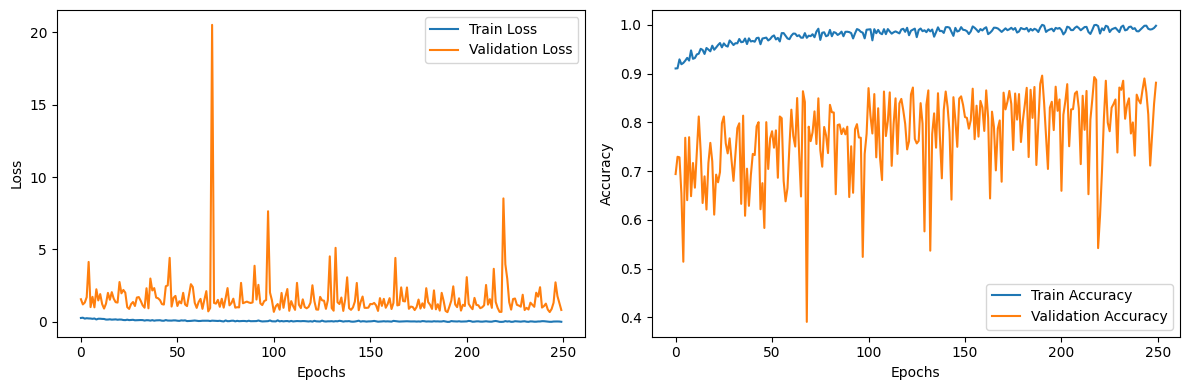

In [140]:
plot_loss_accuracy_curves(rn_history)

It appears that our accuracy and loss are going well, for the most part.  let's train for another 10, and then if that still looks good, go for much longer

In [138]:
rn_history = ResNet.fit(train_data,
                        epochs=250,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/250
332/332 [==============================] - 29s 87ms/step - loss: 0.2720 - accuracy: 0.9105 - val_loss: 1.5639 - val_accuracy: 0.6938
Epoch 2/250
332/332 [==============================] - 28s 85ms/step - loss: 0.2883 - accuracy: 0.9109 - val_loss: 1.2057 - val_accuracy: 0.7293
Epoch 3/250
332/332 [==============================] - 28s 85ms/step - loss: 0.2270 - accuracy: 0.9292 - val_loss: 1.3349 - val_accuracy: 0.7282
Epoch 4/250
332/332 [==============================] - 28s 86ms/step - loss: 0.2534 - accuracy: 0.9192 - val_loss: 1.7102 - val_accuracy: 0.6537
Epoch 5/250
332/332 [==============================] - 28s 86ms/step - loss: 0.2383 - accuracy: 0.9218 - val_loss: 4.1399 - val_accuracy: 0.5140
Epoch 6/250
332/332 [==============================] - 29s 86ms/step - loss: 0.2331 - accuracy: 0.9265 - val_loss: 1.0225 - val_accuracy: 0.7683
Epoch 7/250
332/332 [==============================] - 28s 86ms/step - loss: 0.2119 - accuracy: 0.9322 - val_loss: 1.7318 - val_ac

In [139]:
ResNet.save("../models/MyResNet")

INFO:tensorflow:Assets written to: ../models/MyResNet/assets


INFO:tensorflow:Assets written to: ../models/MyResNet/assets


In [148]:
val_loss, val_acc = ResNet.evaluate(val_data)
print("Test loss:", val_loss)
print("Test accuracy:", val_acc)

108/108 [==============================] - 3s 23ms/step - loss: 0.8249 - accuracy: 0.8813
Test loss: 0.8248757719993591
Test accuracy: 0.8812572956085205


88%, not too shabby!

In [141]:
#TODO put in utils

import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils

def predict_random_image(model : tf.keras.Sequential, target_dir, class_names):

    #print("Target Dir: ", target_dir)
    i =0
    random_folder_str = random.sample(os.listdir(target_dir), 1)[0]
    random_folder = os.path.join(target_dir, random_folder_str)
    while not os.path.isdir(random_folder): 
        # print("random folder/file", random_folder.as_posix())
        i+=1
        random_folder_str = random.sample(os.listdir(target_dir), 1)[0]
        random_folder = os.path.join(target_dir, random_folder_str)
        if i > 10 :
            break
    #print("RandomFolder", random_folder)
    # Get a random image path
    random_image = random.sample(os.listdir(random_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(random_folder + "/" + random_image[0])
    ##plt.imshow(img)
    plt.title(random_folder)
    plt.axis("off")

    #resize and reshape
    image = image_utils.load_img(random_folder + "/" + random_image[0], color_mode="rgb", target_size=(224,224)) 
    plt.imshow(image)   
    image = image_utils.img_to_array(image)
    print(f"Image shape: {image.shape}") # show the shape of the image
    
    image = image/255 # normalize
    image = image.reshape(1, 224, 224, 3) # reshape
    print(f"Image shape: {image.shape}") # show the shape of the image
    predictions = model.predict(image)
    #predictions = model.predict_classes(image)  #deprecated
    print("Prediction: ", class_names[np.argmax(predictions[0])])
    #print("Predictions: ", np.array(class_names)[predictions])
    return predictions

Image shape: (224, 224, 3)
Image shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 369ms/step
Prediction:  Eriogonum_umbellatum


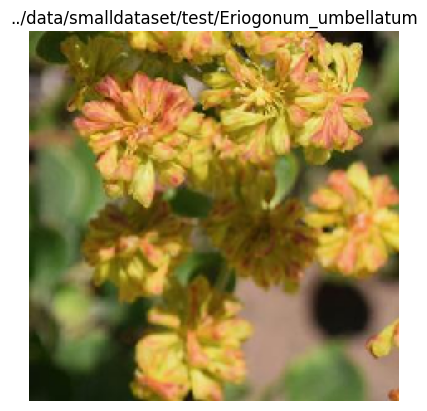

In [149]:
pred = predict_random_image(ResNet, test_dir, class_names)